In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

# Model Development

In [2]:
train_dataset = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test_dataset = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

In [3]:
pd.options.display.float_format = '{:.3f}'.format # Set display option for 3 decimal places

## Explaratory Data Analysis &  Data Preprocessing

In [4]:
#Dropping duplicates
# duplicated_rows = train_dataset[train_dataset.duplicated(keep=False)]
# print(f"Duplicated values (before dropping): {duplicated_rows.sum()}")
train_dataset.drop_duplicates(inplace=True)
# print(f"Duplicated values (after dropping): {train_dataset.duplicated().sum()}")

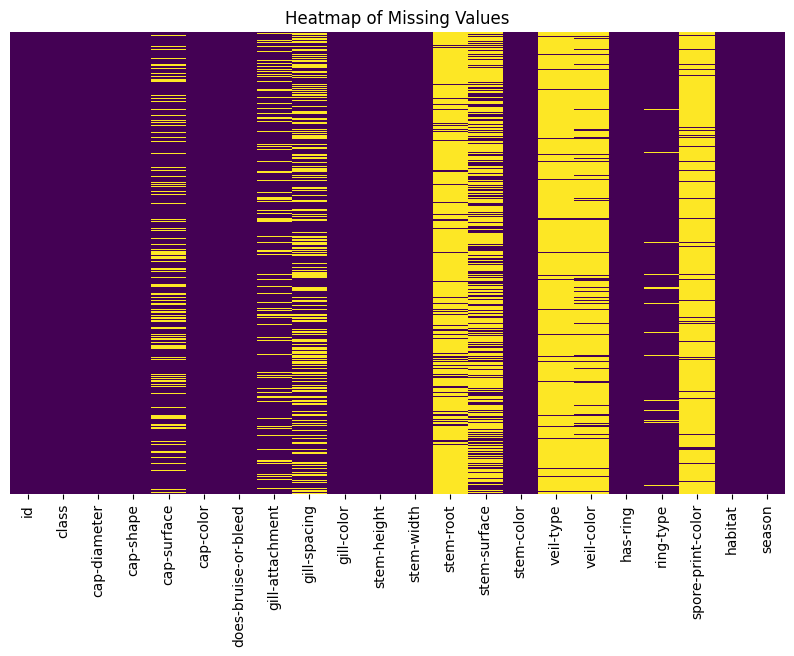

In [5]:
# Create a heatmap to visualize the null values
plt.figure(figsize=(10, 6))
sb.heatmap(train_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

In [6]:
train_dataset.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [7]:
# Impute missing numerical values
train_dataset['cap-diameter'].fillna(train_dataset['cap-diameter'].mean(), inplace=True)  # Fill with mean
# train_dataset['stem-height'].fillna(train_dataset['stem-height'].median(), inplace=True)  # Fill with median
# train_dataset['stem-width'].fillna(0, inplace=True)  # Fill with a specific value

In [8]:
#dropping following columns because of missing values
# train_dataset.drop(['stem-root','stem-surface','veil-type','veil-color', 'spore-print-color'], axis=1,inplace=True)

#Impute missing Categorical columns
train_df_col_names = train_dataset.select_dtypes(include="object").columns
# print(train_df_col_names)
for col_name in train_df_col_names:
    train_dataset[col_name].fillna('na', inplace=True)

In [9]:
#Cardinality of categorical columns
for col_name in train_df_col_names:
#     train_dataset[col_name].fillna("na", inplace=True)
    print(f"{col_name} : {len(train_dataset[col_name].unique())}")

class : 2
cap-shape : 75
cap-surface : 84
cap-color : 79
does-bruise-or-bleed : 27
gill-attachment : 79
gill-spacing : 49
gill-color : 64
stem-root : 39
stem-surface : 61
stem-color : 60
veil-type : 23
veil-color : 25
has-ring : 24
ring-type : 41
spore-print-color : 33
habitat : 53
season : 4


- High Cardinality: If a categorical feature has a very large number of unique categories (high cardinality), one-hot encoding can lead to a large number of columns, which might be inefficient. In such cases, you might consider techniques like Target Encoding or simply drop the feature if it's not important.
- Feature Importance: Random Forest models can still work well even with label encoding for nominal variables, but this might introduce unintended ordinal relationships. One-Hot Encoding is generally safer for nominal variables.

## Split dataset into training and test set

In [22]:
X = train_dataset.drop(['id', 'class'], axis=1)
y = train_dataset['class']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Encoding target variable & categorical variables

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [26]:
import category_encoders as ce
target_encoder = ce.TargetEncoder(cols= train_df_col_names.drop('class'))
X_train = target_encoder.fit_transform(X_train, y_train)
X_test = target_encoder.transform(X_test)

## Correlation matrix

In [ ]:
correlation_matrix = X_train.corr().round(2)

plt.figure(figsize=(12, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
# stem-width and cap-diameter are highly correlated 

## Feature Scaling

In [28]:
#Feature scaling is not necessary for a random forest classifier. But it slighly increase the accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_cols = ['cap-diameter','stem-height', 'stem-width']
ct = ColumnTransformer(transformers=[('feature_scaler', StandardScaler(), numerical_cols)] , remainder='passthrough' )

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

## Hyper Parameter Tuning using GridSearchCV

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

mcc_scorer = make_scorer(matthews_corrcoef)

parameters = {'n_estimators':[20, 30, 40]}
grid_search =GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters,n_jobs=-1, scoring=mcc_scorer, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................n_estimators=20;, score=0.984 total time= 4.1min
[CV 4/5] END ...................n_estimators=20;, score=0.984 total time= 4.1min
[CV 3/5] END ...................n_estimators=20;, score=0.984 total time= 4.2min
[CV 2/5] END ...................n_estimators=20;, score=0.984 total time= 4.2min
[CV 5/5] END ...................n_estimators=20;, score=0.983 total time= 4.2min
[CV 3/5] END ...................n_estimators=30;, score=0.984 total time= 6.2min
[CV 1/5] END ...................n_estimators=30;, score=0.984 total time= 6.5min
[CV 2/5] END ...................n_estimators=30;, score=0.984 total time= 6.9min
[CV 4/5] END ...................n_estimators=30;, score=0.984 total time= 6.1min
[CV 5/5] END ...................n_estimators=30;, score=0.984 total time= 6.3min
[CV 1/5] END ...................n_estimators=40;, score=0.984 total time= 8.5min
[CV 2/5] END ...................n_estimators=40;,

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [20, 30, 40]},
             scoring=make_scorer(matthews_corrcoef), verbose=3)

In [34]:
grid_search.cv_results_

{'mean_fit_time': array([242.72709417, 373.99073596, 471.51023898]),
 'std_fit_time': array([ 2.39885162, 16.61832034, 39.99714483]),
 'mean_score_time': array([ 6.23396301,  9.20085015, 10.3942277 ]),
 'std_score_time': array([0.15668233, 0.27993707, 1.48201139]),
 'param_n_estimators': masked_array(data=[20, 30, 40],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20}, {'n_estimators': 30}, {'n_estimators': 40}],
 'split0_test_score': array([0.98386661, 0.9842328 , 0.98411378]),
 'split1_test_score': array([0.9837708 , 0.98388215, 0.98403596]),
 'split2_test_score': array([0.98362495, 0.98408045, 0.98414868]),
 'split3_test_score': array([0.98357151, 0.98388786, 0.98394176]),
 'split4_test_score': array([0.98332251, 0.98356676, 0.98359872]),
 'mean_test_score': array([0.98363128, 0.98393001, 0.98396778]),
 'std_test_score': array([0.00018644, 0.00022375, 0.00019777]),
 'rank_test_score': array([3, 2, 1], dtype

In [37]:
print(f'best estimator: {grid_search.best_estimator_}')
print(f'best MCC score: {grid_search.best_score_}')

best estimator: RandomForestClassifier(n_estimators=40)
best MCC score: 0.9839677791288384


In [38]:
y_pred_grid_searchcv = grid_search.predict(X_test)

In [39]:
matthews_corrcoef(y_test, y_pred_grid_searchcv)

0.9843241538918458

## Training Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=15)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=15)

In [19]:
y_pred = clf.predict(X_test)

In [20]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
print(conf_matrix)

[[0.99186796 0.00813204]
 [0.00820977 0.99179023]]


In [21]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

0.9835008900156038

# Predicting Submission Set

In [40]:
# Impute missing numerical values
test_dataset['cap-diameter'].fillna(test_dataset['cap-diameter'].mean(), inplace=True)  # Fill with mean
test_dataset['stem-height'].fillna(test_dataset['stem-height'].mean(), inplace=True)
test_dataset['stem-width'].fillna(test_dataset['stem-width'].mean(), inplace=True)

test_df_col_names = test_dataset.select_dtypes(include="object").columns
# print(test_df_col_names)
for col_name in test_df_col_names:
    test_dataset[col_name].fillna('na', inplace=True)

In [41]:
#Finding cardinality of categorical columns
for col_name in test_df_col_names:
#     train_dataset[col_name].fillna("na", inplace=True)
    print(f"{col_name} : {len(test_dataset[col_name].unique())}")

cap-shape : 63
cap-surface : 60
cap-color : 58
does-bruise-or-bleed : 23
gill-attachment : 67
gill-spacing : 36
gill-color : 57
stem-root : 32
stem-surface : 55
stem-color : 56
veil-type : 16
veil-color : 24
has-ring : 24
ring-type : 37
spore-print-color : 34
habitat : 40
season : 4


In [42]:
X_submission = test_dataset.drop(['id'], axis=1)

In [45]:
X_submission_encoded = target_encoder.transform(X_submission)
X_submission_encoded_scaled = ct.transform(X_submission_encoded)

In [46]:
# predict
pred = grid_search.predict(X_submission_encoded_scaled)

In [47]:
predictions = label_encoder.inverse_transform(pred)

In [ ]:
predictions[0:10]

In [48]:
y_pred = pd.DataFrame({'id': test_dataset['id'], 'class': predictions})

In [49]:
y_pred.tail()

,id,class
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e
2077963,5194908,e


In [ ]:
test_dataset.tail()

In [50]:
y_pred.to_csv('submission_feature_scale.csv', index=False)